In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/HEX New folder'

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline



# normalize inputs from 0-255 to 0-1
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder





In [ ]:
import pandas.util.testing as tm

In [ ]:
def ReshapeY(Y_train,n):
    Y = list()
    for x in Y_train:
        Y.append(find_1(x, n))

    Y = np.array(Y)
    return Y
    print(Y.shape)
    
    
# look for 1 ( spoof) in each   
def find_1(x, n):
    if 1 in x:
        res = 1
    else: 
        res = 0
    return res    




    
def LOAD_data(path ):
    filenames = glob.glob(path + "/*.csv")

    dfs = []
    for filename in filenames:
        df=pd.read_csv(filename)
        if 'le0.csv'== filename[-7:]:
            df['attack'] = 0
            df = df[190:]

        else:
            df['attack'] = 1
        dfa = df['attack']
        df = df[14:]
        df = df.iloc[:-180]
        df = df.select_dtypes(exclude=['object','bool'])         #remove nan
        df = df.loc[:, (df != 0).any(axis=0)]                    #remove zeros
        df = df.drop(df.std()[(df.std() == 0)].index, axis=1)   #remove equals
        df=((df-df.min())/(df.max()-df.min()))*1

        df['attack'] = dfa
        dfs.append(df)


    # Concatenate all data into one DataFrame
    df = pd.concat(dfs, ignore_index=True)
        #df.head()
        
    
    # Concatenate all data into one DataFrame
    df = pd.concat(dfs, ignore_index=True)
    #df.head()

    df = df.select_dtypes(exclude=['object','bool'])         #remove nan
    df = df.loc[:, (df != 0).any(axis=0)]                    #remove zeros
    df = df.drop(df.std()[(df.std() == 0)].index, axis=1)   #remove equals

    sf = df[['roll', 'pitch', 'heading', 'rollRate', 'pitchRate', 'yawRate',
       'groundSpeed',  'altitudeRelative', 
       'throttlePct', 'estimatorStatus.horizPosRatio',
       'estimatorStatus.vertPosRatio',
       'estimatorStatus.horizPosAccuracy','gps.courseOverGround']]
    scaled_data = scale(sf)
    

    pca = PCA(n_components = 9)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)

    pca_data = pd.DataFrame(pca_data)

    df_sf = pd.concat([pca_data, df[['attack']]], axis=1)

    sf_t =df_sf

    data_dim = sf_t.shape[1] -1
    timesteps = 60
    num_classes = 2


    X = sf_t.drop(['attack'], axis =1).values
    Y = sf_t[['attack']].values


    ll = sf_t.shape[0] // timesteps
    ll

    x = np.array(X[0: (timesteps*ll)])
    y = np.array(Y[0: (timesteps*ll)])
    x.shape

    X_t = np.reshape(x,(-1,timesteps,data_dim))
    Y_t = np.reshape(y,(-1,timesteps,1))


    Y_t = ReshapeY(Y_t,timesteps )
    print(X_t.shape)
    print(Y_t.shape)

    lb_make = LabelEncoder()
    Y_t = lb_make.fit_transform(Y_t)
    Y_t = tf.keras.utils.to_categorical(Y_t)
    X_t = X_t.astype("float32")
    Y_t = Y_t.astype("float32")
    X_t /= 255
    
    return (X_t,Y_t)


def put_together(combined_array, asd):
    combined_array = np.concatenate((combined_array, asd), axis=0)
    #combined_array = np.delete(combined_array, 0, axis=0)
    return combined_array


def Delete_first(combined_array):
    combined_array = np.delete(combined_array, 0, axis=0)
    return combined_array

In [ ]:
#pa = data_dir + '/h480'

In [ ]:
import os
 
paths = []    
# rootdir = r'C:\Users\lenovo\OneDrive - aggies.ncat.edu\Desktop\new correct files\HEX New folder'
for file in os.listdir(data_dir):
    d = os.path.join(data_dir, file)
    if os.path.isdir(d):
        paths.append(d)

In [ ]:
paths

['/content/drive/My Drive/Colab Notebooks/HEX New folder/ST NPLANE New folder',
 '/content/drive/My Drive/Colab Notebooks/HEX New folder/QUAD New folder',
 '/content/drive/My Drive/Colab Notebooks/HEX New folder/TAIL VTOL New folder',
 '/content/drive/My Drive/Colab Notebooks/HEX New folder/h480']

In [ ]:
from sklearn.preprocessing import scale

i = 0
for path in paths:
    (Xa,Ya) = LOAD_data(path)
    if  (i == 0):
        X_ = Xa  
        Y_ = Ya
        i = i + 1 
    else:
        X_ = np.concatenate((X_, Xa), axis=0)
        Y_ = np.concatenate((Y_, Ya), axis=0)

(461, 60, 9)
(461,)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(2325, 60, 9)
(2325,)
(455, 60, 9)
(455,)
(603, 60, 9)
(603,)


In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [ ]:
X_train.shape

(3075, 60, 9)

In [ ]:
data_dim = X_.shape[2]
timesteps = 60
num_classes = 2

In [ ]:
model = Sequential()

model.add(LSTM(units = X_.shape[2], return_sequences = True, input_shape = (timesteps, data_dim)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 5))
model.add(Dropout(0.2))

model.add(Dense(units = 2, activation='softmax'))


model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs = 100, batch_size = 32,  validation_data=(X_test, y_test))

Epoch 1/100
97/97 [==============================] - 19s 116ms/step - loss: 0.6303 - accuracy: 0.7104 - val_loss: 0.5859 - val_accuracy: 0.7178
Epoch 2/100
97/97 [==============================] - 9s 95ms/step - loss: 0.5358 - accuracy: 0.7640 - val_loss: 0.4169 - val_accuracy: 0.8427
Epoch 3/100
97/97 [==============================] - 9s 94ms/step - loss: 0.4061 - accuracy: 0.8456 - val_loss: 0.4103 - val_accuracy: 0.8401
Epoch 4/100
97/97 [==============================] - 9s 94ms/step - loss: 0.4039 - accuracy: 0.8560 - val_loss: 0.3998 - val_accuracy: 0.8466
Epoch 5/100
97/97 [==============================] - 9s 94ms/step - loss: 0.4037 - accuracy: 0.8482 - val_loss: 0.4156 - val_accuracy: 0.8388
Epoch 6/100
97/97 [==============================] - 9s 94ms/step - loss: 0.4661 - accuracy: 0.8072 - val_loss: 0.3943 - val_accuracy: 0.8518
Epoch 7/100
97/97 [==============================] - 9s 95ms/step - loss: 0.4019 - accuracy: 0.8562 - val_loss: 0.4275 - val_accuracy: 0.8440
Epoc

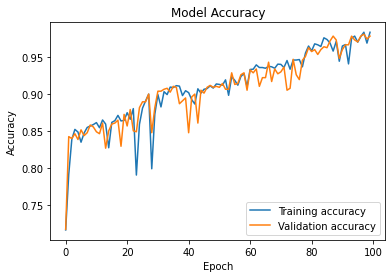

In [ ]:
import keras
from matplotlib import pyplot as plt
#history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

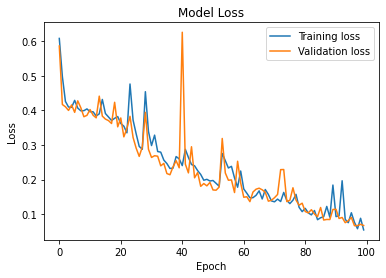

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
 y_pred = model.predict(X_test)

In [ ]:
 y_pred.round()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       217
           1       1.00      0.97      0.98       552

   micro avg       0.98      0.98      0.98       769
   macro avg       0.97      0.98      0.97       769
weighted avg       0.98      0.98      0.98       769
 samples avg       0.98      0.98      0.98       769

Confusion matrix, without normalization
[[537  15]
 [  2 215]]


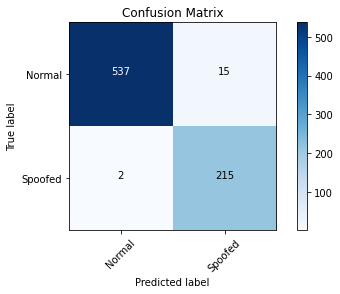

In [ ]:
ypreddf = pd.DataFrame(y_pred.round())
ytestdf = pd.DataFrame(y_test)

from sklearn.metrics import classification_report, confusion_matrix
import itertools

print (classification_report(y_test, y_pred.round()))


cm = confusion_matrix(ytestdf[0], ypreddf[0])
cm_plot_labels = ['Normal','Spoofed']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score,recall_score, precision_score

print("Avg F1-score: %.4f" % f1_score(y_test, y_pred.round(), average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, y_pred.round(), average='weighted'))
print("Recall score: %.4f" % recall_score(y_test, y_pred.round(), average='weighted'))
print("Precision score: %.4f" % precision_score(y_test, y_pred.round(), average='weighted'))

Avg F1-score: 0.9781
Jaccard score: 0.9573
Recall score: 0.9779
Precision score: 0.9789


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Avg F1-score: %.4f" % accuracy_score(y_test, y_pred.round()))

Avg F1-score: 0.9779


###  epsilon < 10 meters